In [1]:
# check package versions
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage

print('Python: {}'.format(sys.version))
print('Keras: {}'.format(keras.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('NumPy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))


Using TensorFlow backend.


Python: 3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:43:00) 
[GCC 7.5.0]
Keras: 2.3.1
OpenCV: 4.6.0
NumPy: 1.18.5
Matplotlib: 3.2.2
Scikit-Image: 0.16.2


In [2]:

# import the necessary packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os
import glob
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores


In [4]:
# # prepare degraded images by introducing quality distortions via resizing

# def prepare_images(path, factor):
    
#     # loop through the files in the directory
#     for file in os.listdir(path):
        
#         # open the file
#         img = cv2.imread(path + '/' + file)
        
#         # find old and new image dimensions
#         h, w, _ = img.shape
#         new_height = h / factor
#         new_width = w / factor
        
#         # resize the image - down
#         img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
#         # resize the image - up
#         img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
#         # save the image
#         print('Saving {}'.format(file))
#         cv2.imwrite('images/{}'.format(file), img)


In [5]:
plain_datagen = ImageDataGenerator()
scaled_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
hr_image_raw_dict = {}
lr_image_raw_dict = {}




def load_images(standardize= False, resize = False, resize_width = None, resize_height = None):
    hr_image_list = glob.glob('../ML-project/Data/HR/*')
    
    for i in tqdm(hr_image_list):
        filename_wo_ext = i.split('/')[-1].split('.')[0]
        
        if resize:
            hr_image_raw_dict[filename_wo_ext] = cv2.resize(cv2.imread(i),fx = resize_height,
                                                           fy = resize_width)
        else:
            
            hr_image_raw_dict[filename_wo_ext] = cv2.imread(i)
        
        if standardize:
            hr_image_raw_dict[filename_wo_ext] = hr_image_raw_dict[filename_wo_ext]/255.0 
            
            
        
        
    lr_image_list = glob.glob('../ML-project/Data/LR/*')
    
    for i in tqdm(lr_image_list):
        filename_wo_ext = i.split('/')[-1].split('.')[0]
        if resize:
            lr_image_raw_dict[filename_wo_ext] = cv2.resize(cv2.imread(i),fx = resize_height,
                                                           fy = resize_width)
        else:
            
            lr_image_raw_dict[filename_wo_ext] = cv2.imread(i)
        #lr_image_raw_dict[filename_wo_ext] = cv2.imread(i)    
        
        if standardize:
            lr_image_raw_dict[filename_wo_ext] = lr_image_raw_dict[filename_wo_ext]/255.0 
            
        
    return hr_image_raw_dict, lr_image_raw_dict   

In [7]:
import tqdm
import cv2
import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
#%tensorflow_version 2.x
#import tensorflow as tf
#from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator

import math
from keras import backend as K
hr_image_raw_dict, lr_image_raw_dict = load_images(standardize = False, resize = False, resize_width = None, resize_height = None)


100%|██████████| 100/100 [00:00<00:00, 2335.02it/s]


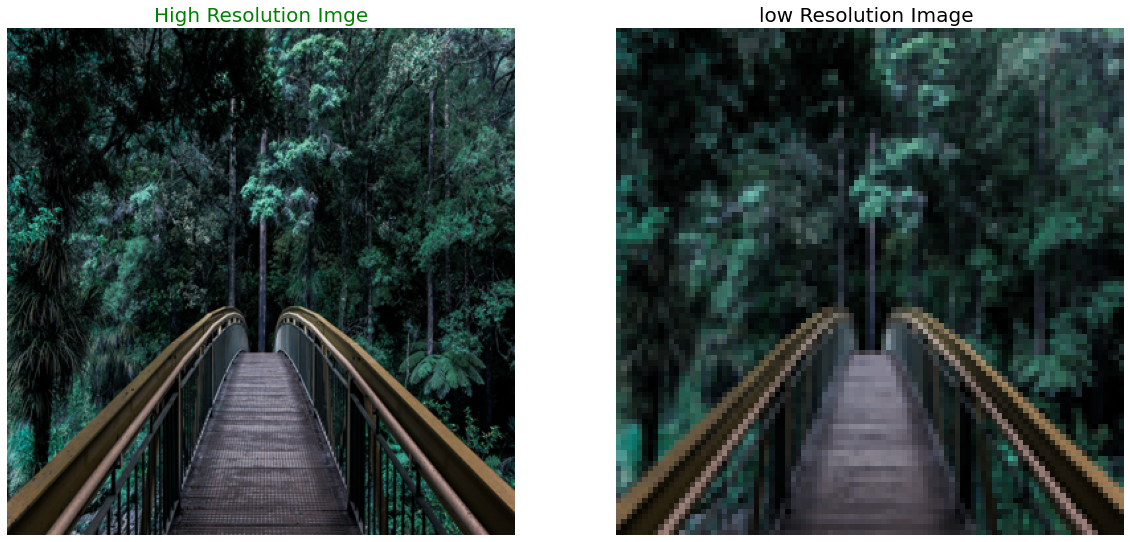

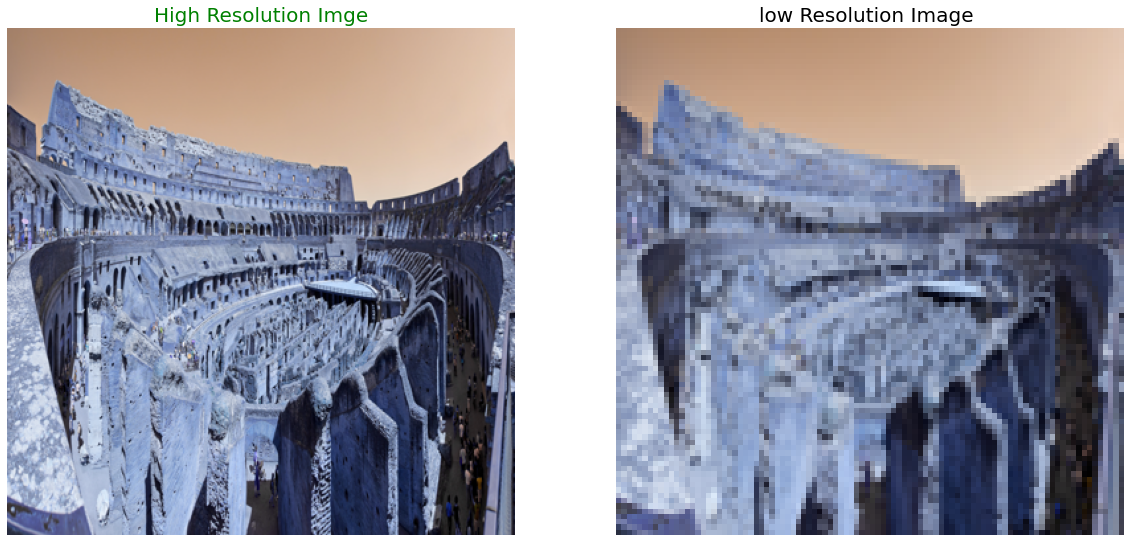

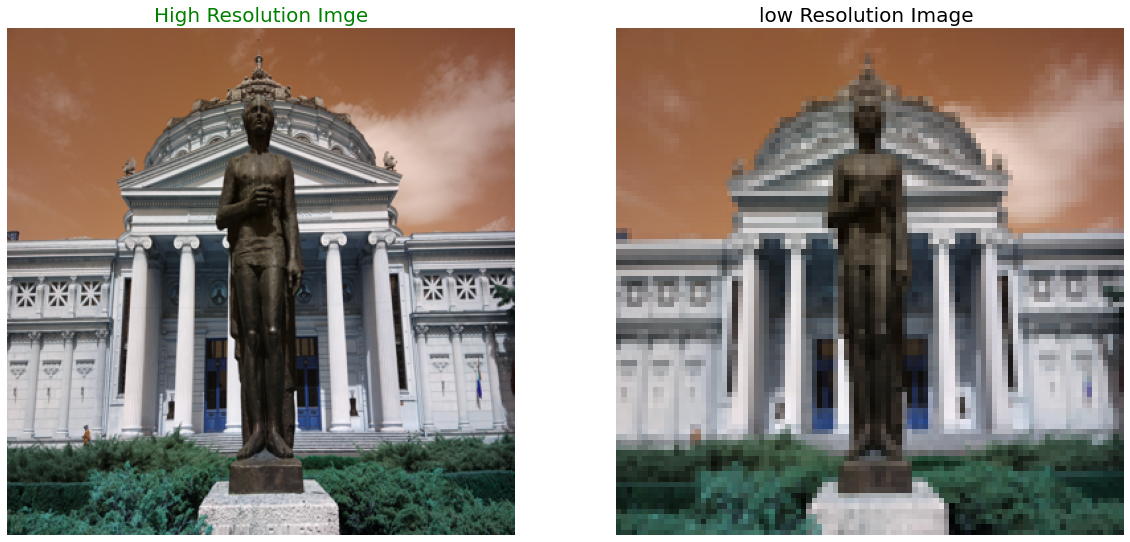

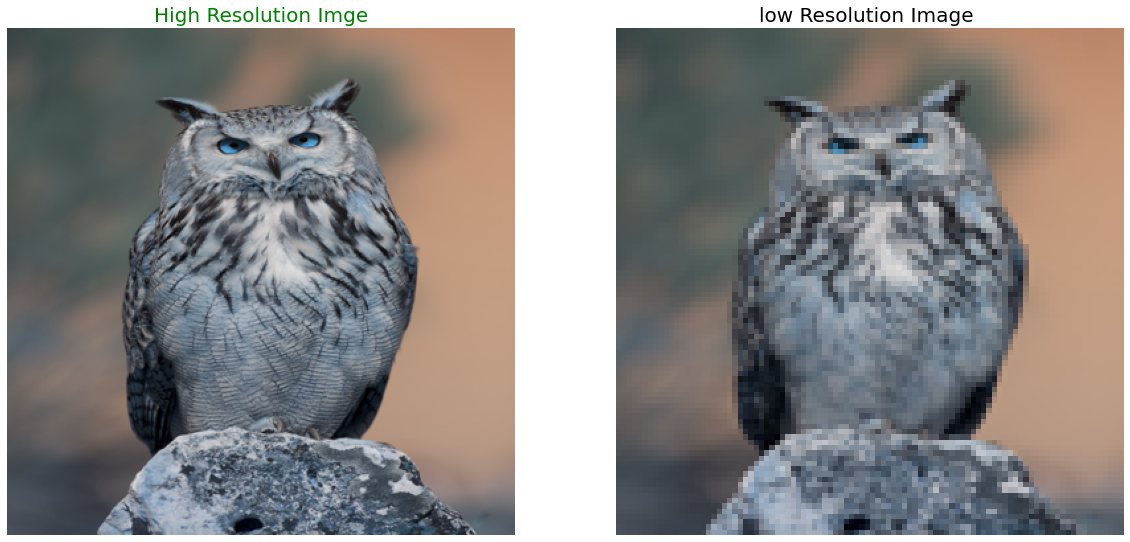

In [8]:
for i in range(4):
    a = str(np.random.randint(0,99))
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(hr_image_raw_dict[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(lr_image_raw_dict[a])
    plt.axis('off')

In [9]:
def model_train_plot(history):
    
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    

    plt.plot(history.history['SSIM'])
    plt.plot(history.history['val_SSIM'])
    plt.title('model SSIM')
    plt.ylabel('SSIM')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['PSNR'])
    plt.plot(history.history['val_PSNR'])
    plt.title('model PSNR')
    plt.ylabel('PSNR')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [10]:
def build_model():
    model = keras.Sequential()
    model.add(keras.Input(shape = (96,96,3)))
    model.add(layers.Conv2D(filters = 32, kernel_size= 3, padding = 'same', strides = 1,activation='relu'))
    model.add(layers.Conv2D(filters = 64, kernel_size= 3, padding = 'same', activation='relu'))
    model.add(layers.Conv2D(filters = 128, kernel_size= 9, padding = 'same', activation='relu' ))
    model.add(layers.Conv2D(filters = 64, kernel_size= 9, padding = 'same', activation='relu'))
    model.add(layers.UpSampling2D(size = (2,2)))
    model.add(layers.Conv2D(filters = 64, kernel_size= 3, padding = 'same', activation='relu'))
    model.add(layers.Conv2D(filters = 128, kernel_size= 9, padding = 'same', activation='relu'))
    model.add(layers.Conv2D(filters = 32, kernel_size= 3, padding = 'same', activation='relu'))
    model.add(layers.Conv2D(filters = 32, kernel_size= 3, padding = 'same', activation='relu'))
    model.add(layers.UpSampling2D(size = (2,2)))
    model.add(layers.Dense(3, activation="relu"))
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(optimizer = opt, loss = 'MSE', metrics = [PSNR, 'accuracy', SSIM])
    model.summary()

In [11]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

def SSIM(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

In [12]:
x_train = lr_image_raw_dict.values()
y_train = hr_image_raw_dict.values()
x_train = np.array(list(x_train))
y_train = np.array(list(y_train))

train_iterator_plain = plain_datagen.flow(x_train, y_train, batch_size=2)
print(train_iterator_plain)
model = build_model()

#model.fit(train_iterator_plain, batch_size=2, epochs=2000, verbose= 0 )



TypeError: The added layer must be an instance of class Layer. Found: Tensor("input_1:0", shape=(None, 96, 96, 3), dtype=float32)

In [ ]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(x_train, y_train, batch_size=2, epochs=200, verbose= 0,callbacks=[earlystop_callback], validation_split = 0.2)
